In [2]:
import numpy as np
root = '../../'
caffe_root = root + 'caffe/'  # this file is expected to be in {caffe_root}/examples
import sys
sys.path.insert(0, caffe_root + 'python')
import caffe
import os
import random

In [2]:
DATA_DIR='../../dataset/cuhk01/cuhk01/'
file_list_a=os.listdir(DATA_DIR)

In [3]:
def readList(name_list,name_dict): 
    import random
    import os
    probes=[]
    gallerys=[]
    for key in name_list:
        probes.append(name_dict[key][random.randint(0,1)])
        gallerys.append(name_dict[key][random.randint(2,3)])
    if len(probes)!=len(gallerys):
        print('something wrong! list length does not match!/n')
        return 0
    else:
        return probes,gallerys
def generateScoreList(net,probes,gallerys):
    transformer = caffe.io.Transformer({'data': (net.blobs['data'].data.shape)})
    transformer.set_transpose('data', (2,0,1))
    transformer.set_mean('data', np.array([ 104.00698793,  116.66876762,  122.67891434])) # mean pixel
    transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
    transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB
    
    scoreList=[]
    N,C,H,W=net.blobs['data'].data.shape
    from time import clock
    start=clock()
    #galleryData is same for each probe
    galleryLen=len(gallerys)
    galleryDataList=[]
    for galleryIdx in range(galleryLen):
        galleryName=gallerys[galleryIdx]
        galleryImage=transformer.preprocess('data', caffe.io.load_image(galleryName))
        galleryDataList.append(galleryImage)
        galleryIdx+=1
    #galleryData and probeData
    galleryData=np.asarray(galleryDataList)
    probeData=np.zeros((galleryLen,C,H,W))
    
    net.blobs['data'].reshape(galleryLen,C,H,W)
    net.blobs['data_p'].reshape(galleryLen,C,H,W)
    #process each probe
    for probeIdx in range(len(probes)):
        probeName=probes[probeIdx]
        probeImage=transformer.preprocess('data', caffe.io.load_image(probeName))
        #batch data assignment
        probeData[:,:,:,:]=probeImage
        net.blobs['data'].data[:] = probeData
        net.blobs['data_p'].data[:] = galleryData
        #net forwad
        net.forward()
        #get output score
        outScore=net.blobs['softmax_score'].data[:,(0,1)]    #softmax_score[0] and softmax_score[1]
        score_sum=np.exp(outScore[:,0]*1.0)+np.exp(outScore[:,1]*1.0)
        similarScore=outScore[:,1]#np.exp(outScore[:,1]*1.0)/score_sum
        #scoreList.append each probe score
        scoreList.append(similarScore.tolist())
        if (probeIdx+1)%10==0:
            sys.stdout.write('\r%3d/%d, '%(probeIdx+1,len(probes))+probeName)
            sys.stdout.flush()
    #we get scoreList, then cal predictLists
    predictLists=[]
    for score in scoreList:
        probeRankList=np.argsort(score)[::-1]
        predictLists.append(probeRankList)
    finish=clock()
    print('\r  Processing %dx%d pairs cost %f second time'%(len(probes),len(gallerys),(finish-start)))
    return scoreList,predictLists

def calCMC(net,set_no,rand_times=10):
    from cmc import evaluateCMC


    #rand 10 times for stable result
    cmc_list=[]
    for i in range(rand_times):
        print 'Round %d with rand list:'%i
        probes,gallerys=readList(list_name)
        scoreList,predictLists=generateScoreList(net,probes,gallerys)
        gtLabels=range(len(probes))
        cmc=evaluateCMC(gtLabels,predictLists)
        cmc_list.append(cmc)
    return np.average(cmc_list,axis=0)

def getCVPRcmc():
    #return the cmc values, 100 dim vetor
    import numpy as np
    cmcIndex=[0,4,8,12,16,21,25,29,33,37,41,45,49,53]
    cmcOfCVPRImproved=[0.5474,0.8753,0.9293,0.9712,0.9764,0.9811,0.9899,0.9901,0.9912,0.9922,0.9937,0.9945,0.9951,1]
    pOfCVPRImproved = np.poly1d(np.polyfit(cmcIndex,cmcOfCVPRImproved,10))
    x_line=range(50)
    cmc=pOfCVPRImproved(x_line)
    return cmc


In [4]:
name_dict={}

for name in file_list_a:
    if name[-3:]=='png':
        id = name[:4]
        if not name_dict.has_key(id):
            name_dict[id]=[]
        name_dict[id].append(DATA_DIR+name)  

print len(name_dict)
print name_dict['0003']

971
['../../dataset/cuhk01/cuhk01/0003001.png', '../../dataset/cuhk01/cuhk01/0003003.png', '../../dataset/cuhk01/cuhk01/0003002.png', '../../dataset/cuhk01/cuhk01/0003004.png']


In [5]:
cmcDict={}
cmc_list=[]

In [6]:
# choose test ids:
test_id_number = 486
set_no = 1
phase = 'test'
filename_test = '../../dataset/cuhk01/exp_set/testid%03d_set%02d_%s.txt'%(test_id_number,(set_no),phase)
print filename_test

file_object = open(filename_test)
try:
    all_the_text = file_object.read( )
finally:
    file_object.close( )

test_dict = {}

lines = all_the_text.split('\n')
for filename in lines:
    if filename!='':
        if name_dict.has_key(filename):
            test_dict[filename] = name_dict[filename]
print len(test_dict)

key_list = []
for key in test_dict.keys():
    key_list.append(key)

key_list_shuffle = key_list[:]
random.shuffle(key_list_shuffle)
probes,gallerys=readList(key_list_shuffle[:],test_dict)
print len(key_list)

from cmc import evaluateCMC
MODEL_FILE = '../../experiments/reid_earlyfusion_google_bigmap_cuhk01_486id/set01/deploy.prototxt'
PRETRAINED = '../../experiments/reid_earlyfusion_google_bigmap_cuhk01_486id/set01/Snapshots/set01_iter_50000.caffemodel'
caffe.set_device(1)
caffe.set_mode_gpu()
net = caffe.Classifier(MODEL_FILE, PRETRAINED,caffe.TEST)
for i in range(5):
    print 'Round %d with rand list:'%i
    key_list_shuffle = key_list[:]
    random.shuffle(key_list_shuffle)
    probes,gallerys=readList(key_list_shuffle[:],name_dict)
    scoreList,predictLists=generateScoreList(net,probes,gallerys)
    gtLabels=range(len(probes))
    cmc=evaluateCMC(gtLabels,predictLists)
    cmc_list.append(cmc)

../../dataset/cuhk01/exp_set/testid486_set01_test.txt
486
486
Round 0 with rand list:
  Processing 486x486 pairs cost 383.392795 second time
Round 1 with rand list:
  Processing 486x486 pairs cost 377.827932 second time
Round 2 with rand list:
  Processing 486x486 pairs cost 370.245841 second time
Round 3 with rand list:
  Processing 486x486 pairs cost 376.172494 second time
Round 4 with rand list:
  Processing 486x486 pairs cost 371.421974 second time


In [8]:
# choose test ids:
test_id_number = 486
set_no = 2
phase = 'test'
filename_test = '../../dataset/cuhk01/exp_set/testid%03d_set%02d_%s.txt'%(test_id_number,(set_no),phase)
print filename_test

file_object = open(filename_test)
try:
    all_the_text = file_object.read( )
finally:
    file_object.close( )

test_dict = {}

lines = all_the_text.split('\n')
for filename in lines:
    if filename!='':
        if name_dict.has_key(filename):
            test_dict[filename] = name_dict[filename]
print len(test_dict)

key_list = []
for key in test_dict.keys():
    key_list.append(key)

key_list_shuffle = key_list[:]
random.shuffle(key_list_shuffle)
probes,gallerys=readList(key_list_shuffle[:],test_dict)
print len(key_list)

from cmc import evaluateCMC
MODEL_FILE = '../../experiments/reid_earlyfusion_google_bigmap_cuhk01_486id/set01/deploy.prototxt'
PRETRAINED = '../../experiments/reid_earlyfusion_google_bigmap_cuhk01_486id/set02/Snapshots/set02_iter_50000.caffemodel'
caffe.set_device(1)
caffe.set_mode_gpu()
net = caffe.Classifier(MODEL_FILE, PRETRAINED,caffe.TEST)
for i in range(3):
    print 'Round %d with rand list:'%i
    key_list_shuffle = key_list[:]
    random.shuffle(key_list_shuffle)
    probes,gallerys=readList(key_list_shuffle[:],name_dict)
    scoreList,predictLists=generateScoreList(net,probes,gallerys)
    gtLabels=range(len(probes))
    cmc=evaluateCMC(gtLabels,predictLists)
    cmc_list.append(cmc)

../../dataset/cuhk01/exp_set/testid486_set02_test.txt
486
486
Round 0 with rand list:
  Processing 486x486 pairs cost 393.049555 second time
Round 1 with rand list:
  Processing 486x486 pairs cost 394.538611 second time
Round 2 with rand list:
  Processing 486x486 pairs cost 394.642276 second time


In [7]:
cmc_all = np.average(cmc_list,axis=0)
print cmc_all
cmcDict['ours (GN, hnm)'] = cmc_all

[ 0.7654321   0.85432099  0.90329218  0.92962963  0.94238683  0.95102881
  0.9600823   0.96502058  0.9691358   0.97489712  0.97613169  0.97736626
  0.97860082  0.97983539  0.98148148  0.981893    0.98312757  0.98436214
  0.98477366  0.98683128  0.9872428   0.9872428   0.98847737  0.98847737
  0.98888889  0.98930041  0.98930041  0.98930041  0.98971193  0.98971193
  0.99012346  0.99012346  0.99053498  0.99053498  0.99053498  0.99053498
  0.99053498  0.9909465   0.99218107  0.99218107  0.99259259  0.99259259
  0.99300412  0.99300412  0.99341564  0.99423868  0.99465021  0.99465021
  0.99465021  0.99465021  0.99465021  0.99506173  0.99506173  0.99506173
  0.99506173  0.99547325  0.99547325  0.99547325  0.99547325  0.99547325
  0.99547325  0.99547325  0.99547325  0.99547325  0.99547325  0.99547325
  0.99547325  0.99547325  0.99588477  0.99588477  0.99588477  0.99588477
  0.99588477  0.9962963   0.9962963   0.9962963   0.9962963   0.9962963
  0.99711934  0.99711934  0.99711934  0.99711934  0.

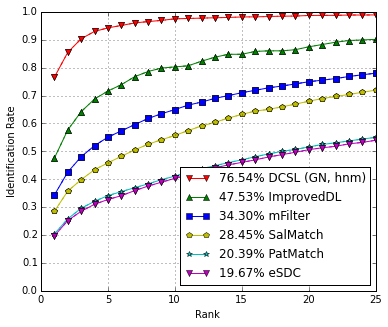

In [3]:
import scipy.io as sio
data = sio.loadmat('/mnt/share/Temp/reid_mat/cuhk01_486ID.mat')['data']
from eval_cuhk03 import plotCMC
cmcDict={}
cmcDict['ImprovedDL'] = data[0]/100
#cmcDict['visWord'] = data[1]/100
#cmcDict['l1-norm'] = data[2]
#cmcDict['l2-norm'] = data[3]
#cmcDict['SDALF'] = data[4]
cmcDict['eSDC'] = data[5]/100
#cmcDict['LMNN'] = data[6]/100
#cmcDict['ITML'] = data[7]
#cmcDict['genericmetric'] = data[8]
cmcDict['PatMatch'] = data[9]/100
cmcDict['SalMatch'] = data[10]/100
cmcDict['mFilter'] = data[11]/100
cmcDict['DCSL (GN, hnm)']=load_list['ours (GN, hnm)']

#plot the dictionary, sorted by rank1 rate

save_path = 'cuhk01_id486_set02.png'
plotCMC(cmcDict,save_path)

In [10]:
print len(cmcDict)

6


In [11]:
import pickle
cmcDict_bk = cmcDict
f1 = open("res_cuhk01_486id.txt","wb")
pickle.dump(cmcDict, f1)
f1.close()

# READ

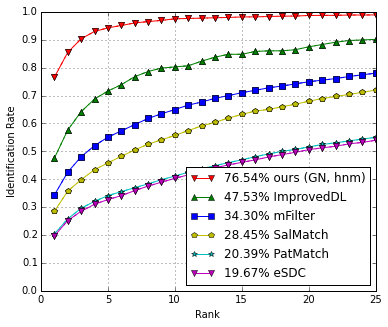

In [1]:
import pickle
from eval_cuhk03 import plotCMC
f2 = open("res_cuhk01_486id.txt","rb")
load_list = pickle.load(f2)
f2.close()
save_path = '../../paper/cuhk01_486ID.png'
plotCMC(load_list,save_path)

In [13]:
from tabulate import tabulate
import scipy.io as sio

load_dict = dict(load_list)

data = sio.loadmat('/mnt/share/Temp/reid_mat/cuhk01_486ID.mat')['data']

load_dict['ImprovedDL'] = data[0]/100
#cmcDict['visWord'] = data[1]/100
#cmcDict['l1-norm'] = data[2]
#cmcDict['l2-norm'] = data[3]
#cmcDict['SDALF'] = data[4]
load_dict['eSDC'] = data[5]/100
#cmcDict['LMNN'] = data[6]/100
#cmcDict['ITML'] = data[7]
#cmcDict['genericmetric'] = data[8]
load_dict['PatMatch'] = data[9]/100
load_dict['SalMatch'] = data[10]/100
load_dict['mFilter'] = data[11]/100

methods = ['ours (GN, hnm)','ImprovedDL','eSDC','PatMatch','SalMatch']
table = []
for mtd in methods:
    this_list = []
    this_list.append(mtd)
    this_list.append(load_dict[mtd][0]*100)
    this_list.append(load_dict[mtd][1]*100)
    this_list.append(load_dict[mtd][4]*100)
    this_list.append(load_dict[mtd][9]*100)
    table.append(this_list)

print table

[['ours (GN, hnm)', 76.543209876543216, 85.432098765432102, 94.238683127572003, 97.489711934156361], ['ImprovedDL', 47.530864197530867, 57.613168724279838, 71.604938271604937, 80.246913580246911], ['eSDC', 19.670781893004115, 25.164609053497944, 32.716049382716051, 40.288065843621396], ['PatMatch', 20.390946502057616, 25.761316872427987, 34.115226337448554, 41.090534979423872], ['SalMatch', 28.449999999999996, 35.724999999999994, 45.850000000000009, 55.674999999999997]]


In [14]:
print tabulate(table,headers=["Method","r = 1", "r = 2", "r = 5", "r = 10"], tablefmt="latex",floatfmt=".2f")

\begin{tabular}{lrrrr}
\hline
 Method         &   r = 1 &   r = 2 &   r = 5 &   r = 10 \\
\hline
 ours (GN, hnm) &   76.54 &   85.43 &   94.24 &    97.49 \\
 ImprovedDL     &   47.53 &   57.61 &   71.60 &    80.25 \\
 eSDC           &   19.67 &   25.16 &   32.72 &    40.29 \\
 PatMatch       &   20.39 &   25.76 &   34.12 &    41.09 \\
 SalMatch       &   28.45 &   35.72 &   45.85 &    55.67 \\
\hline
\end{tabular}
